In [43]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install torchvision

In [45]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [46]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a prte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

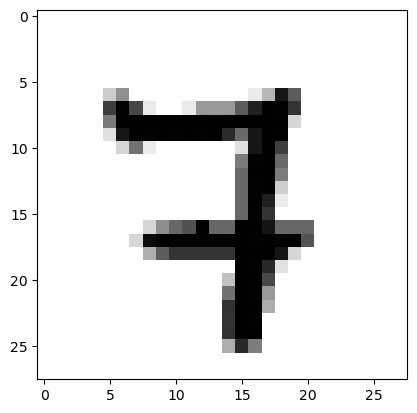

In [47]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [48]:
# Para verificar as dimensões do tensor de cada imagem
print(imagens[0].shape)
# Para verificar as dimensões do tensor de cada etiqueta
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [49]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # Camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)# Camda interna 2, 64 neurônios que se ligam a 10
        # Para a camada de saida não é necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self, X):
        X = F.relu(self.linear1(X)) # Função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # Função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # Função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [50]:
def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e das bias
    inicio = time() # Timer para sabermos quanto tempo levou o treino
    
    criterio = nn.NLLLoss() # Definindo o critério para calcular a perda
    EPOCHS = 10 # numero de epochs que o algoritmo rodará
    modelo.train() #ativando o modo de treinamento do modelo 
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e as bias
            
            perda_acumulada += perda_instantanea.item() #atualização da perda acumulada
            
        else:
            print("Epoch {} - Perda resultante : {}".format(epoch+1, perda_acumulada/len(trainloader)))
            print("\nTempo de treino (em minutos) = ",time()-inicio/60)

In [59]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            #desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um cuslto alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) #output do modelo em escala logarítmica
                
            ps = torch.exp(logps) # Converte output para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu
            etiqueta_certa = etiquetas.numpy()[i]
            if (etiqueta_certa == etiqueta_pred): #compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1
            
        print("Total de imagens testadas = ", conta_todas)
        print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [52]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [56]:
treino = treino(modelo, trainloader, device)

Epoch 1 - Perda resultante : 1.15182672647525

Tempo de treino (em minutos) =  1681681272.432527
Epoch 2 - Perda resultante : 0.3812013951493606

Tempo de treino (em minutos) =  1681681279.5565283
Epoch 3 - Perda resultante : 0.313661029788731

Tempo de treino (em minutos) =  1681681287.4503932
Epoch 4 - Perda resultante : 0.27493989517662065

Tempo de treino (em minutos) =  1681681294.550136
Epoch 5 - Perda resultante : 0.24419320084805937

Tempo de treino (em minutos) =  1681681301.7977283
Epoch 6 - Perda resultante : 0.21837965099176745

Tempo de treino (em minutos) =  1681681309.4483943
Epoch 7 - Perda resultante : 0.19635896755259302

Tempo de treino (em minutos) =  1681681317.0137162
Epoch 8 - Perda resultante : 0.17768481018335452

Tempo de treino (em minutos) =  1681681324.2846854
Epoch 9 - Perda resultante : 0.16131907044999252

Tempo de treino (em minutos) =  1681681331.9238875
Epoch 10 - Perda resultante : 0.1476546927079209

Tempo de treino (em minutos) =  1681681339.608242

In [60]:
validador = validacao(modelo, valloader, device)

Total de imagens testadas =  64

Precisão do modelo = 95.3125%
Total de imagens testadas =  128

Precisão do modelo = 96.09375%
Total de imagens testadas =  192

Precisão do modelo = 97.39583333333333%
Total de imagens testadas =  256

Precisão do modelo = 94.921875%
Total de imagens testadas =  320

Precisão do modelo = 93.75%
Total de imagens testadas =  384

Precisão do modelo = 94.27083333333333%
Total de imagens testadas =  448

Precisão do modelo = 95.08928571428571%
Total de imagens testadas =  512

Precisão do modelo = 94.921875%
Total de imagens testadas =  576

Precisão do modelo = 95.13888888888889%
Total de imagens testadas =  640

Precisão do modelo = 95.0%
Total de imagens testadas =  704

Precisão do modelo = 95.0284090909091%
Total de imagens testadas =  768

Precisão do modelo = 95.18229166666667%
Total de imagens testadas =  832

Precisão do modelo = 95.1923076923077%
Total de imagens testadas =  896

Precisão do modelo = 95.42410714285714%
Total de imagens testadas =

Total de imagens testadas =  7552

Precisão do modelo = 95.7759533898305%
Total de imagens testadas =  7616

Precisão do modelo = 95.74579831932773%
Total de imagens testadas =  7680

Precisão do modelo = 95.75520833333333%
Total de imagens testadas =  7744

Precisão do modelo = 95.75154958677686%
Total de imagens testadas =  7808

Precisão do modelo = 95.74795081967213%
Total de imagens testadas =  7872

Precisão do modelo = 95.7571138211382%
Total de imagens testadas =  7936

Precisão do modelo = 95.72832661290323%
Total de imagens testadas =  8000

Precisão do modelo = 95.725%
Total de imagens testadas =  8064

Precisão do modelo = 95.74652777777777%
Total de imagens testadas =  8128

Precisão do modelo = 95.75541338582677%
Total de imagens testadas =  8192

Precisão do modelo = 95.76416015625%
Total de imagens testadas =  8256

Precisão do modelo = 95.78488372093024%
Total de imagens testadas =  8320

Precisão do modelo = 95.79326923076923%
Total de imagens testadas =  8384

Precis